
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## HyCReeW: runup estimation of historical nearshore waves at 3 locations

The obtained runup will be used in the next step for obtaining the Daily Weather Types (KMA regression guided with runup data)


inputs required: 
  * Nearshore reconstructed historical waves
  * Historical water levels (astronomical tide)

in this notebook:
  * HyCReWW runup estimation of historical data at 3 different locations


**HyCReWW** provides wave-driven run-up estimations along coral reef-lined shorelines under a wide range of fringing reef morphologies and offshore forcing characteristics. The metamodel is based on two models: (a) a full factorial design of recent XBeach Non-Hydrostatic simulations under different reef configurations and offshore wave and water level conditions (Pearson et al, 2017); and (b) Radial Basis Functions (RBFs) for approximating the non-linear function of run-up for the set of multivariate parameters:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Runup = RBF($\eta_0$, $H_0$, ${H_0/L_0}$, $\beta_f$,$W_reef$, $\beta_b$, $c_f$ );&nbsp;&nbsp;&nbsp;&nbsp;</center>

Where, the hydrodynamic variables defined are offshore water level ($\eta_0$), significant wave height ($H_0$), and wave steepness (${H_0/L_0}$); the reef morphologic parameters include fore reef slope ($\beta_f$), reef flat width ($W_reef$), beach slope ($\beta_b$), and seabed roughness ($c_f$). ${L_0}$ is the deep water wave length $L_0=gT_p^2/2pi$, and $T_p$ is the peak period. Beach crest elevation ($z_b$) was  <font color='red'>fixed at a height of 30 m </font> to focus on run-up as a proxy for coastal inundation.



<img src="fig_esquemas/d_hycreww.png">

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import datetime

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Interpolation
from teslakit.mda import Normalize




## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN_emulator')


# --------------------------------------
# load Hycreww RBF coefficients and sim. variables min. and max.

# reef characteristics
reef_cs = {
    'rslope': 0.0505,
    'bslope': 0.1667,
    'rwidth': 250,
    'cf': 0.0105,
}

var_lims, rbf_coeffs = db.Load_HYCREWW()
print(var_lims)
print()


# --------------------------------------
# Load hourly nearshore waves for 3 points at sections North, East & South

WVS_N = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_nearshore_historical/v4/output_Def_swells/swells_profiles_N.nc') 
WVS_S = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_nearshore_historical/v5/output_Def_swells_1/swells_profiles_S.nc') 
WVS_E = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_nearshore_historical/v5/output_Def_swells_1/swells_profiles_E.nc') 


# N, S, E profiles. Select one profile representative from each section
pN = 28 #(36,22)
pS = 8  #(13,1)
pE = 16 #(21,14)

WVS_N = WVS_N.sel(profile=pN, time=slice(WVS_S.time[0], WVS_S.time[-1]))
WVS_S = WVS_S.sel(profile=pS).drop({'tm', 'dirP', 'dates_sea', 'dates_swell'})
WVS_E = WVS_E.sel(profile=pE).drop({'tm', 'dirP', 'dates_sea', 'dates_swell'})
print(WVS_N)    
print()
print(WVS_S)    
print()
print(WVS_E)    
print()


# --------------------------------------    
# Load astronomical tide from TG

TIDE = db.Load_TIDE_hist_astro()
TIDE = TIDE.drop_vars({'WaterLevels', 'Residual'})
print(TIDE)


{'level': array([-1.,  3.]), 'hs': array([1., 5.]), 'tp': array([ 3.4, 25.5]), 'rslope': array([0.05, 0.5 ]), 'bslope': array([0.05, 0.2 ]), 'rwidth': array([   0., 1500.]), 'cf': array([0.01, 0.1 ]), 'hs_lo2': [0.005, 0.05]}

<xarray.Dataset>
Dimensions:  (time: 359401)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T01:00:00 ... 2020-01-01
    profile  float64 28.0
Data variables:
    hs       (time) float64 ...
    tp       (time) float64 ...
    dir      (time) float64 ...

<xarray.Dataset>
Dimensions:  (time: 359401)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T01:00:00 ... 2020-01-01
    profile  float64 8.0
Data variables:
    hs       (time) float64 ...
    tp       (time) float64 ...
    dir      (time) float64 ...

<xarray.Dataset>
Dimensions:  (time: 359401)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T01:00:00 ... 2020-01-01
    profile  float64 16.0
Data variables:
    hs       (time) float64 ...
    t

## Plot input data

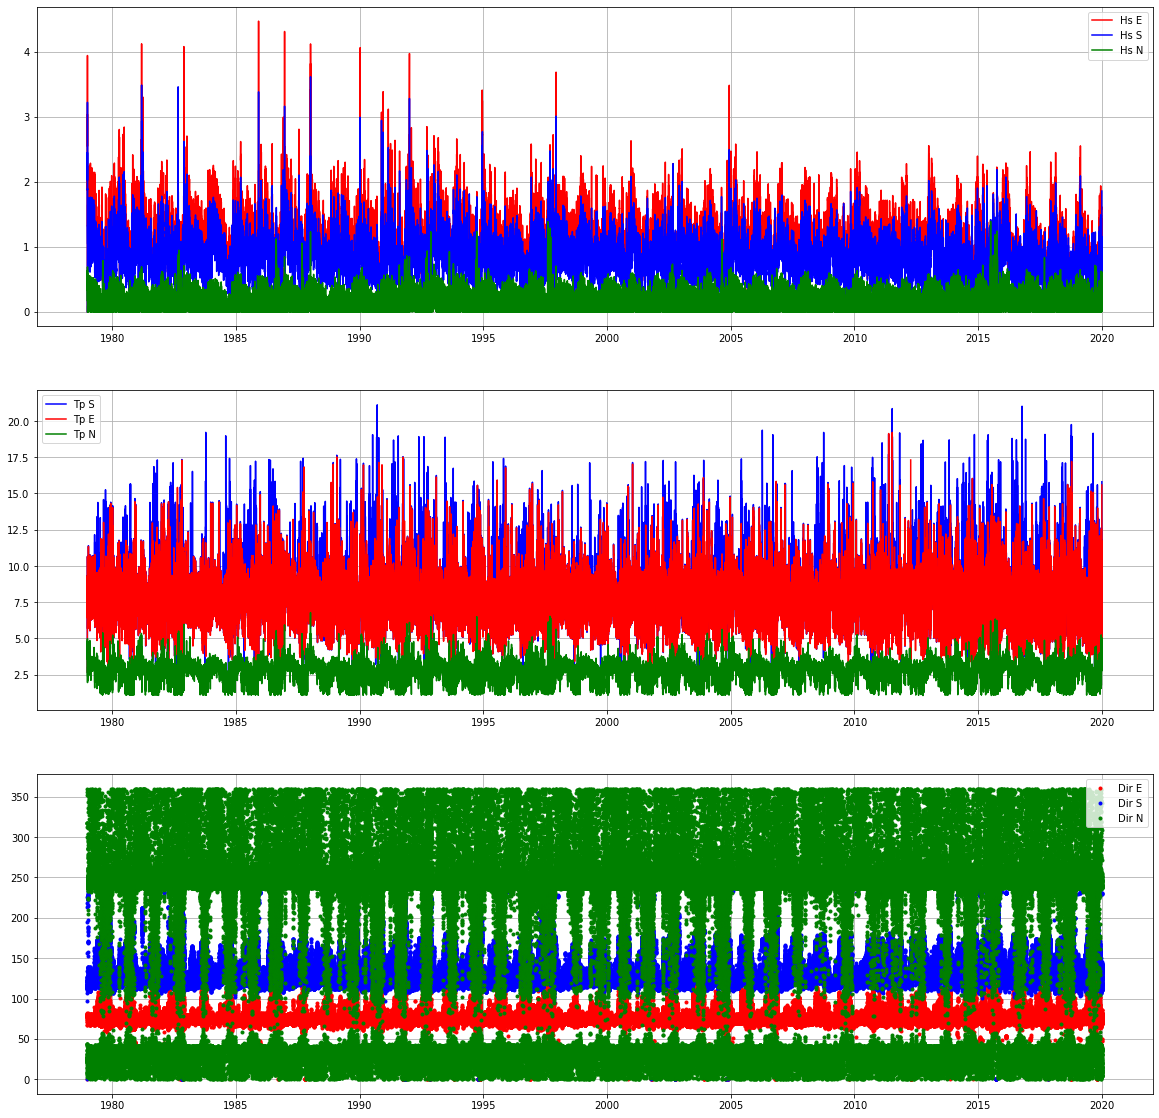

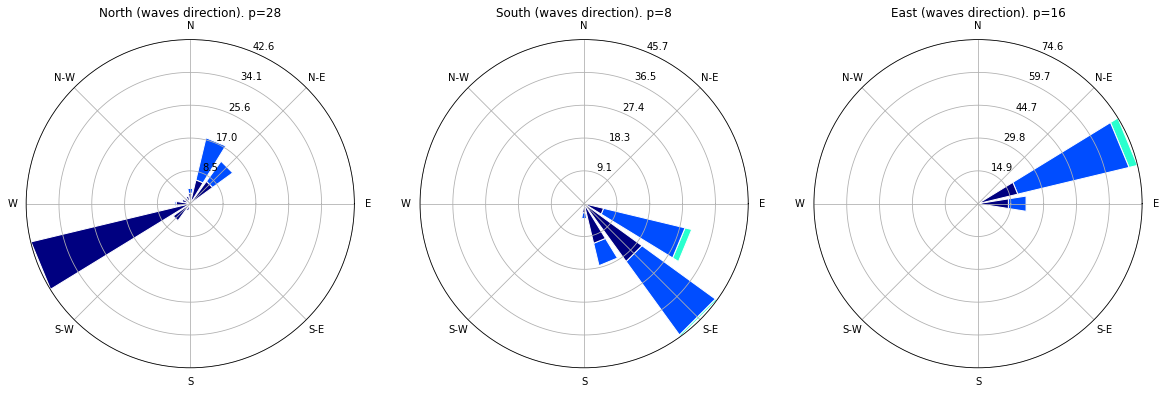

Text(0.5, 1.0, 'Tide (m)')

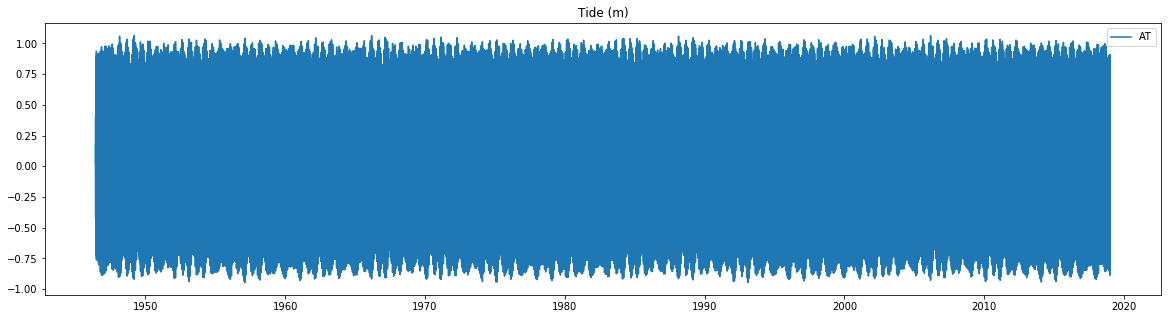

In [3]:
fig, axs = plt.subplots(3,1, figsize=(20,20))

axs[0].plot(WVS_E.time, WVS_E.hs, color = 'r', label='Hs E')
axs[0].plot(WVS_S.time, WVS_S.hs, color = 'b', label='Hs S')
axs[0].plot(WVS_N.time, WVS_N.hs, color = 'g', label='Hs N')
axs[0].legend()
axs[0].legend()
axs[0].grid()

axs[1].plot(WVS_S.time, WVS_S.tp, color = 'b', label='Tp S')
axs[1].plot(WVS_E.time, WVS_E.tp, color = 'r', label='Tp E')
axs[1].plot(WVS_N.time, WVS_N.tp, color = 'g', label='Tp N')
axs[1].legend()
axs[1].grid()

axs[2].plot(WVS_E.time, WVS_E.dir, '.r', label='Dir E')
axs[2].plot(WVS_S.time, WVS_S.dir, '.b', label='Dir S')
axs[2].plot(WVS_N.time, WVS_N.dir, '.g', label='Dir N')
axs[2].legend()
axs[2].grid()

plt.show()


from windrose import WindroseAxes
#fig, axs = plt.subplots(1,3, figsize=(20,7))
#print(axs)

fig=plt.figure(figsize=(20,7))

wa=WindroseAxes(fig, [0.125,0.125,0.227941,0.755])
fig.add_axes(wa)
wa.bar(WVS_N.dir, WVS_N.hs, normed=True, opening=0.8, edgecolor='white')
plt.title('North (waves direction). p=' + str(pN))

wa=WindroseAxes(fig, [0.398529,0.125,0.227941,0.755])
fig.add_axes(wa)
wa.bar(WVS_S.dir, WVS_S.hs, normed=True, opening=0.8, edgecolor='white')
plt.title('South (waves direction). p=' + str(pS))

wa=WindroseAxes(fig, [0.672059,0.125,0.227941,0.755])
fig.add_axes(wa)
wa.bar(WVS_E.dir, WVS_E.hs, normed=True, opening=0.8, edgecolor='white')
plt.title('East (waves direction). p=' + str(pE))
plt.show()


plt.figure(figsize=(20,5))
plt.plot(TIDE.time, TIDE.Predicted, label='AT')
plt.legend()
plt.title('Tide (m)')


## Obtain base level for Hycreww (99th percentile of AT)

In [4]:
# --------------------------------------
# 99% of AT level
AT = TIDE.Predicted - np.nanmean(TIDE.Predicted)

level = np.percentile(AT.values, 99)
print(level)


0.85196490774742



## Hycreww RBF Interpolation: Historical

In [5]:
# hycreww interpolation 

def hycreww_runup(var_lims, rbf_coeffs, dset):
    '''
    Calculates RunUp using hycreww RBFs (level) and linear interpolation (Runup)
    
    var_lims   - hycreww variables min and max limits
    rbf_coeffs - hycreww rbf coefficients
    dset       - input dataset (pandas.DataFrame with "rbf_vns" columns)
    
    '''
    
    # RBF wave conditions 
    rbf_hs = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]
    rbf_hs_lo = [0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05 ]
    rbf_vns = ['level', 'rslope', 'bslope', 'rwidth', 'cf']
    
    # RBF parameters
    ix_sc = [0, 1, 2, 3, 4]
    ix_dr = []
    minis = [var_lims[x][0] for x in rbf_vns]
    maxis = [var_lims[x][1] for x in rbf_vns]
    
    
    # add reef characteristics
    for p in reef_cs.keys():
        dset[p] = reef_cs[p]

    # discard data outside limits
    for vn in var_lims.keys():
        dset = dset[(dset[vn] >= var_lims[vn][0]) &(dset[vn] <= var_lims[vn][1])]        

           
    # RBF dataset to interpolate
    ds_in = dset[rbf_vns]

    # normalize data
    ds_nm ,_ ,_ = Normalize(ds_in.values, ix_sc, ix_dr, minis=minis, maxis=maxis)

    # RBF interpolation (with all cases?)
    ru_out = []
    for rc in rbf_coeffs:
        ro = RBF_Interpolation(rc['constant'], rc['coeff'], rc['nodes'], ds_nm.T)
        ru_out.append(ro)
    ru_z = np.array(ru_out)
    
    # RU Linear interpolation (hs, hs_lo -> runup)
    RU = []
    for c, (_, r) in enumerate(dset.iterrows()):
        vq = griddata((rbf_hs, rbf_hs_lo), ru_z[:,c], (r['hs'], r['hs_lo2']), method='linear')
        RU.append(vq)
    RU = np.array(RU)
    
    # store runup alongside input data
    dset_out = dset.copy()
    dset_out['runup'] = dset_out['level'] + RU

    return dset_out


In [6]:
# Input data for hycreww

WVS_N = WVS_N.drop('profile')
WVS_S = WVS_S.drop('profile')
WVS_E = WVS_E.drop('profile')

WVS_E['level'] = level                                            # add level
WVS_S['level'] = level                                            # add level
WVS_N['level'] = level                                            # add level

WVS_N['hs_lo2'] = WVS_N['hs']/(1.5613*WVS_N['tp']**2)             # calc. hs_lo2
WVS_S['hs_lo2'] = WVS_S['hs']/(1.5613*WVS_S['tp']**2)             # calc. hs_lo2
WVS_E['hs_lo2'] = WVS_E['hs']/(1.5613*WVS_E['tp']**2)             # calc. hs_lo2


### Adjust Hs, Tp & hs_lo2 to fit within Hycreww limits


In [7]:

for var in ['hs', 'tp', 'hs_lo2']:
    WVS_N['{variable}_orig'.format(variable=var)] = WVS_N[var].copy(deep=True)
    WVS_S['{variable}_orig'.format(variable=var)] = WVS_S[var].copy(deep=True)
    WVS_E['{variable}_orig'.format(variable=var)] = WVS_E[var].copy(deep=True)

    
for var in ['hs', 'tp', 'hs_lo2']:
    
    WVS_N[var] =  WVS_N[var].where(WVS_N[var]>=var_lims[var][0], var_lims[var][0] )
    WVS_N[var] =  WVS_N[var].where(WVS_N[var]<=var_lims[var][1], var_lims[var][1] )    
    
    WVS_S[var] =  WVS_S[var].where(WVS_S[var]>=var_lims[var][0], var_lims[var][0] )
    WVS_S[var] =  WVS_S[var].where(WVS_S[var]<=var_lims[var][1], var_lims[var][1] )    
    
    WVS_E[var] =  WVS_E[var].where(WVS_E[var]>=var_lims[var][0], var_lims[var][0] )
    WVS_E[var] =  WVS_E[var].where(WVS_E[var]<=var_lims[var][1], var_lims[var][1] )    
    
    

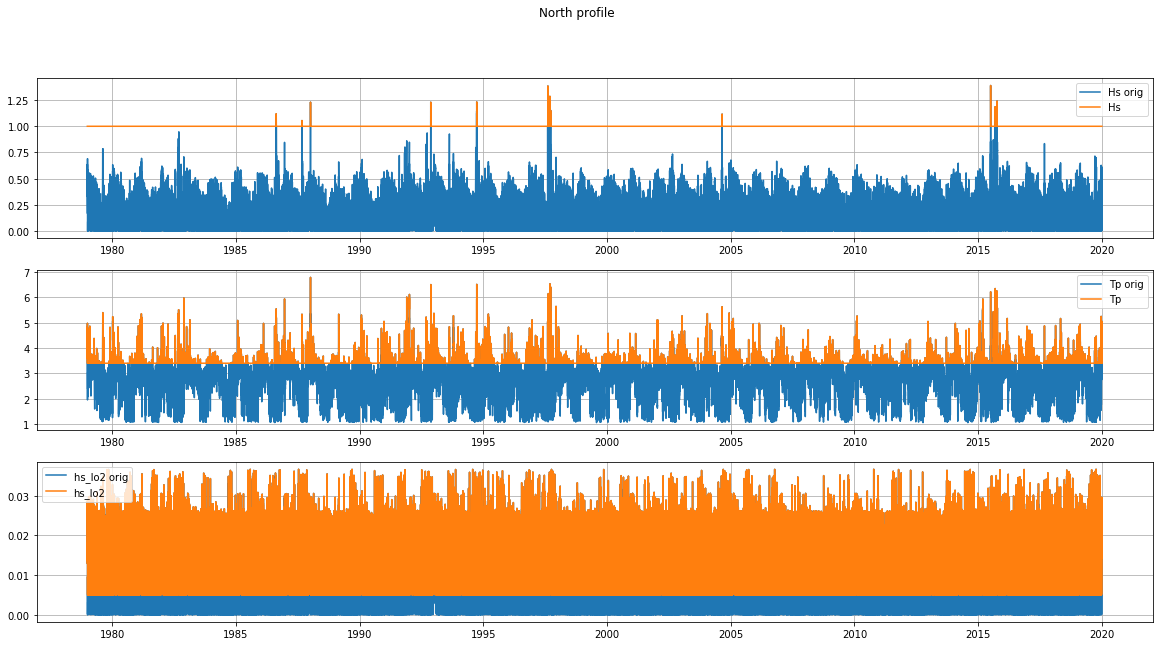

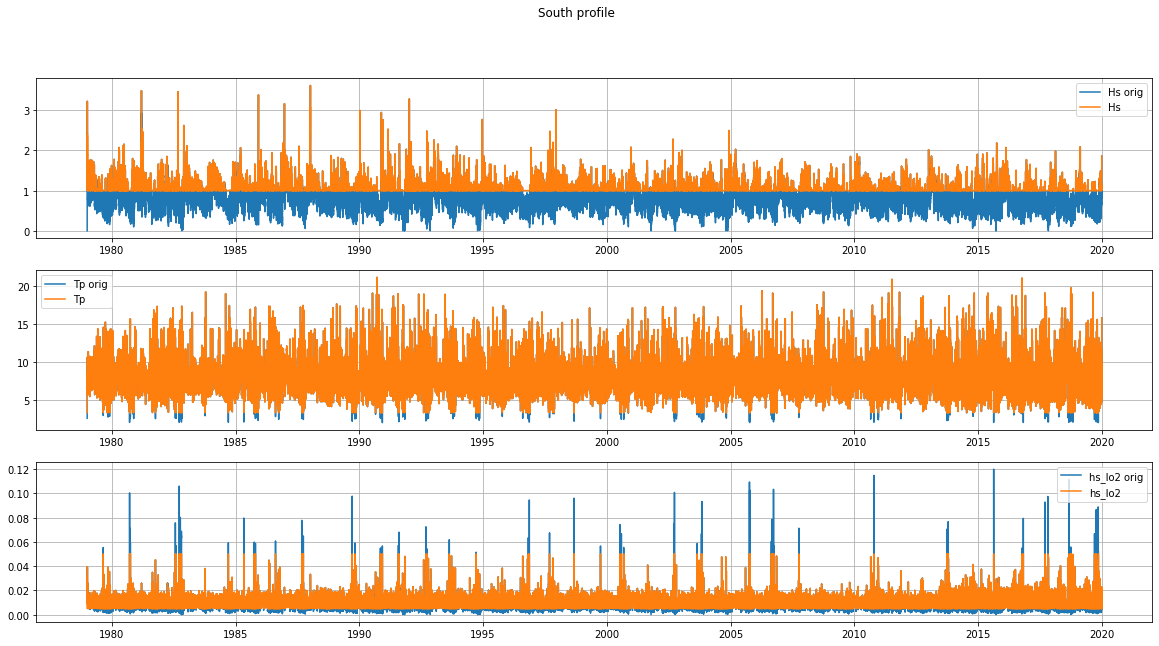

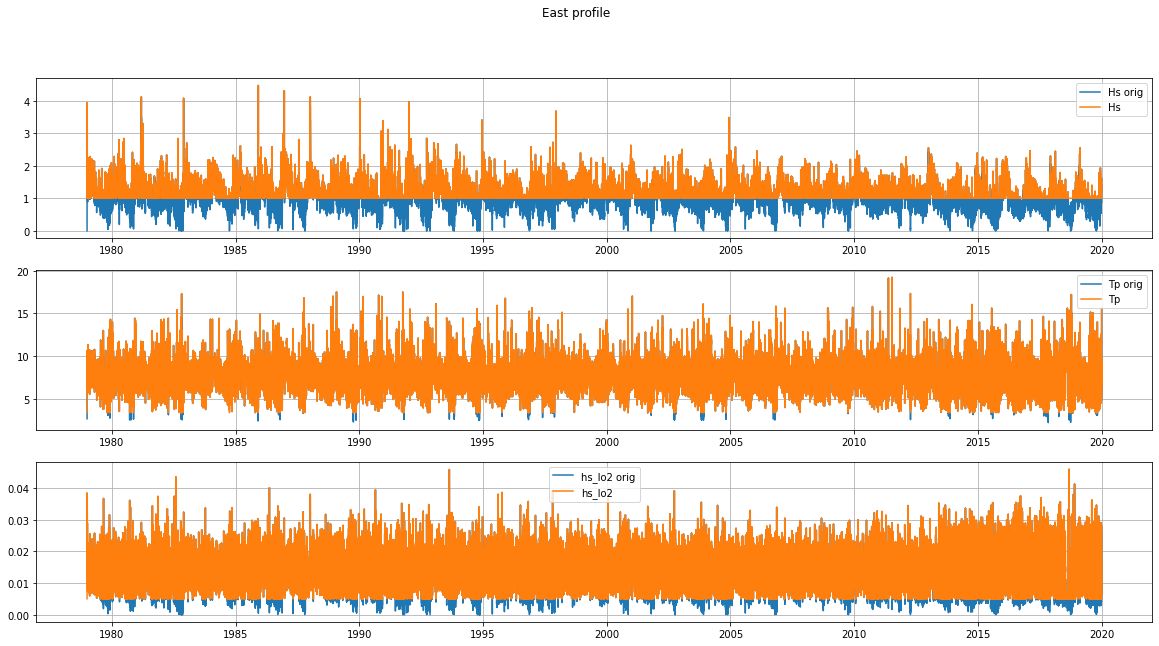

In [8]:
# plot Hs, Tp & hs_lo2 (original and adjusted for Hycreww)

titl = ['North', 'South','East']
WVS_sec = [WVS_N, WVS_S, WVS_E]

for titl_s, WVS_s in zip(titl, WVS_sec):
    
    fig, axs = plt.subplots(3,1,figsize=(20,10))
    fig.suptitle(titl_s + ' profile')
    axs[0].plot(WVS_s.time, WVS_s.hs_orig, label='Hs orig')
    axs[0].plot(WVS_s.time, WVS_s.hs, label='Hs')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(WVS_s.time, WVS_s.tp_orig, label='Tp orig')
    axs[1].plot(WVS_s.time, WVS_s.tp, label='Tp')
    axs[1].legend()
    axs[1].grid()

    axs[2].plot(WVS_s.time, WVS_s.hs_lo2_orig, label='hs_lo2 orig')
    axs[2].plot(WVS_s.time, WVS_s.hs_lo2, label='hs_lo2')
    axs[2].legend()
    axs[2].grid()

    

### Calculate runup with hycreww

In [9]:
# Calculate runup at 3 locations

dset_N = WVS_N[['hs', 'tp', 'dir', 'level', 'hs_lo2']].to_dataframe()
out_hist_N = hycreww_runup(var_lims, rbf_coeffs, dset_N)
print(out_hist_N)
print()

dset_S = WVS_S[['hs', 'tp', 'dir', 'level', 'hs_lo2']].to_dataframe()
out_hist_S = hycreww_runup(var_lims, rbf_coeffs, dset_S)
print(out_hist_S)
print()

dset_E = WVS_E[['hs', 'tp', 'dir', 'level', 'hs_lo2']].to_dataframe()
out_hist_E = hycreww_runup(var_lims, rbf_coeffs, dset_E)
print(out_hist_E)



                      hs        tp        dir     level    hs_lo2  rslope  \
time                                                                        
1979-01-01 00:00:00  1.0  3.599902  26.879115  0.851965  0.028427  0.0505   
1979-01-01 01:00:00  1.0  3.776746  24.292235  0.851965  0.021519  0.0505   
1979-01-01 02:00:00  1.0  3.811160  24.405242  0.851965  0.019656  0.0505   
1979-01-01 03:00:00  1.0  3.818772  24.580990  0.851965  0.019272  0.0505   
1979-01-01 04:00:00  1.0  3.866074  24.594514  0.851965  0.019033  0.0505   
...                  ...       ...        ...       ...       ...     ...   
2019-12-31 20:00:00  1.0  4.144694  14.685322  0.851965  0.020022  0.0505   
2019-12-31 21:00:00  1.0  3.965100  19.444387  0.851965  0.022643  0.0505   
2019-12-31 22:00:00  1.0  3.728691  21.647205  0.851965  0.024474  0.0505   
2019-12-31 23:00:00  1.0  3.715098  24.025214  0.851965  0.026570  0.0505   
2020-01-01 00:00:00  1.0  3.704689  25.669781  0.851965  0.028383  0.0505   

<xarray.Dataset>
Dimensions:  (time: 359401)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T01:00:00 ... 2020-01-01
Data variables:
    hs       (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    tp       (time) float64 3.6 3.777 3.811 3.819 ... 3.965 3.729 3.715 3.705
    dir      (time) float64 26.88 24.29 24.41 24.58 ... 19.44 21.65 24.03 25.67
    level    (time) float64 0.852 0.852 0.852 0.852 ... 0.852 0.852 0.852 0.852
    hs_lo2   (time) float64 0.02843 0.02152 0.01966 ... 0.02447 0.02657 0.02838
    rslope   (time) float64 0.0505 0.0505 0.0505 0.0505 ... 0.0505 0.0505 0.0505
    bslope   (time) float64 0.1667 0.1667 0.1667 0.1667 ... 0.1667 0.1667 0.1667
    rwidth   (time) int64 250 250 250 250 250 250 ... 250 250 250 250 250 250
    cf       (time) float64 0.0105 0.0105 0.0105 0.0105 ... 0.0105 0.0105 0.0105
    runup    (time) float64 1.394 1.488 1.531 1.54 ... 1.463 1.421 1.402 1.394

<xarray.Dataset>
Dimensions:  (time: 359401)
C

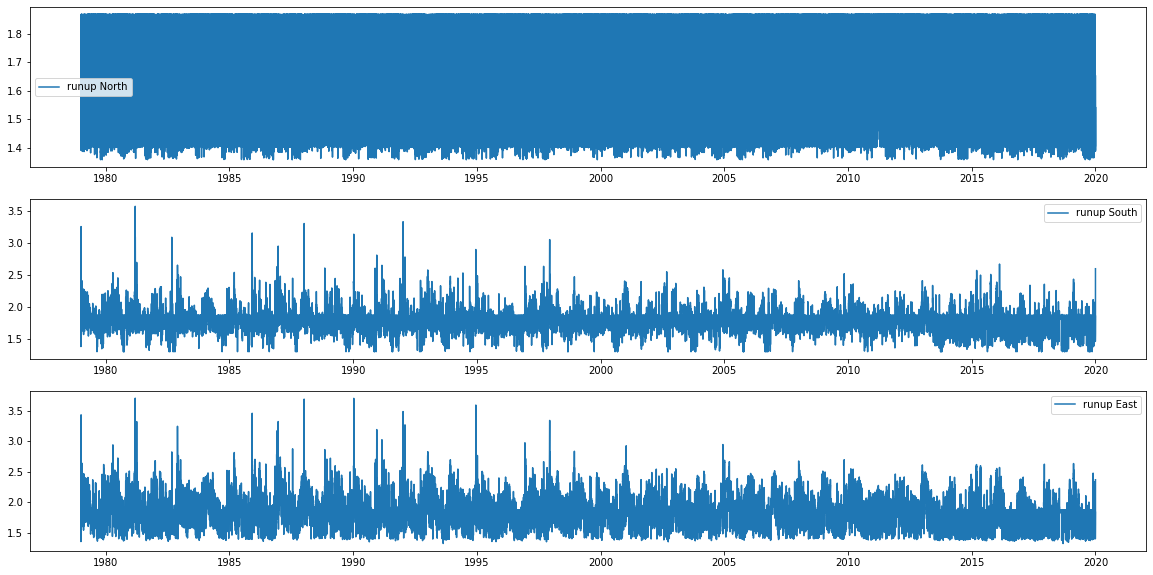

In [10]:
# pandas to xarray

out_hist_N = out_hist_N.to_xarray()
out_hist_S = out_hist_S.to_xarray()
out_hist_E = out_hist_E.to_xarray()

print(out_hist_N)
print()
print(out_hist_S)
print()
print(out_hist_E)


# plot Hycreww output

fig, axs = plt.subplots(3,1,figsize=(20,10))
axs[0].plot(out_hist_N.time, out_hist_N.runup, label='runup North')
axs[0].legend()
axs[1].plot(out_hist_S.time, out_hist_S.runup, label='runup South')
axs[1].legend()
axs[2].plot(out_hist_E.time, out_hist_E.runup, label='runup East')
axs[2].legend()


### Re-scale runup according to original Hs

Text(0.5, 1.0, 'runup East')

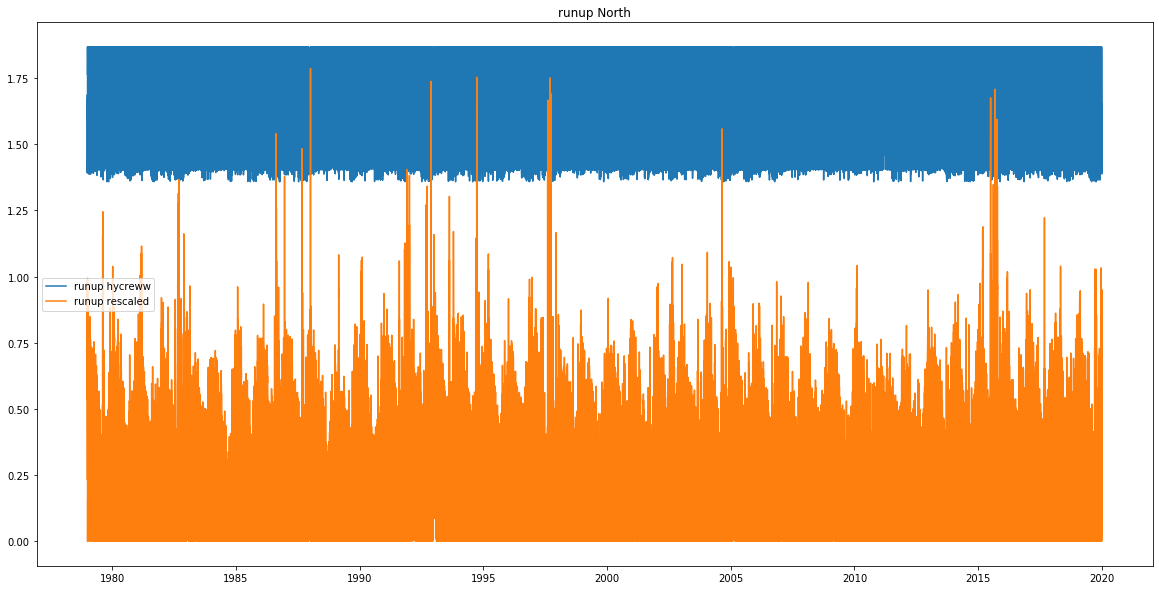

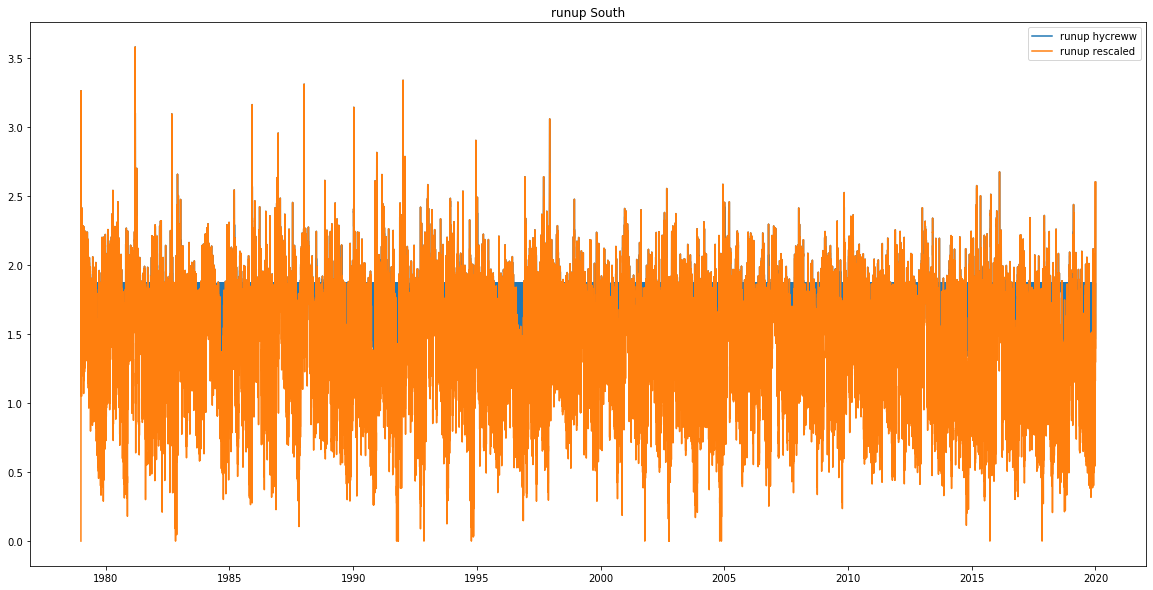

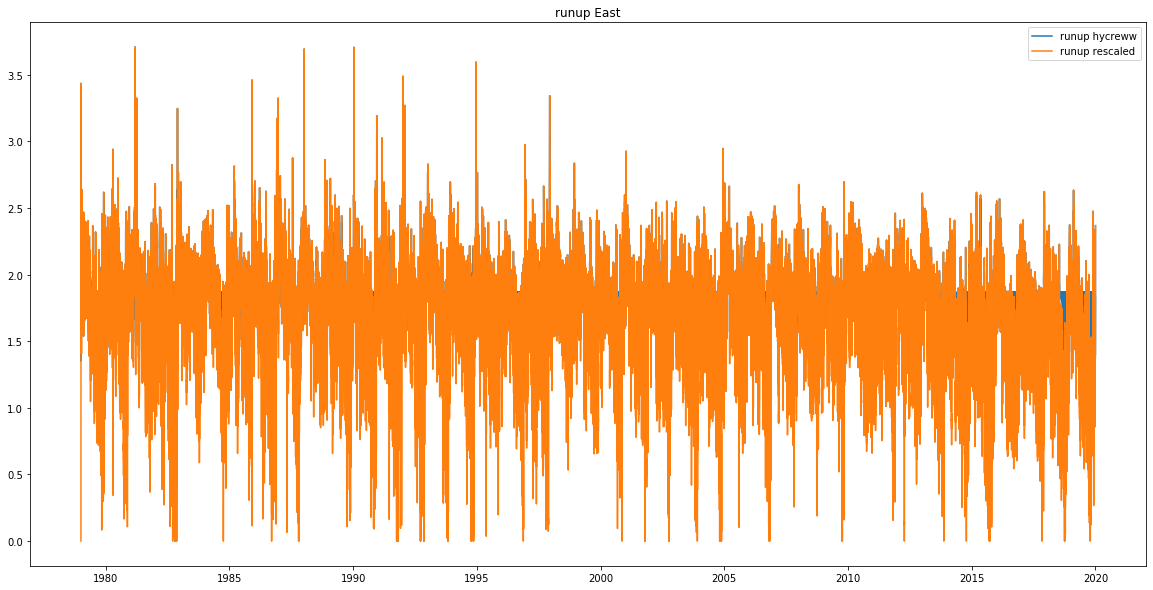

In [11]:

out_hist_N['runup_orig'] = out_hist_N['runup'].copy(deep=True)
out_hist_S['runup_orig'] = out_hist_S['runup'].copy(deep=True)
out_hist_E['runup_orig'] = out_hist_E['runup'].copy(deep=True)


# re-adjust by Hs min lim. (For waves lower than 1m, multiply runup by the original waves value)
    
out_hist_N['runup_orig'] = out_hist_N['runup_orig'].where(WVS_N['hs_orig']>=var_lims['hs'][0], out_hist_N['runup_orig']*WVS_N['hs_orig'])
out_hist_S['runup_orig'] = out_hist_S['runup_orig'].where(WVS_S['hs_orig']>=var_lims['hs'][0], out_hist_S['runup_orig']*WVS_S['hs_orig'])
out_hist_E['runup_orig'] = out_hist_E['runup_orig'].where(WVS_E['hs_orig']>=var_lims['hs'][0], out_hist_E['runup_orig']*WVS_E['hs_orig'])


# re-adjust by Hs max lim

out_hist_N['runup_orig'] = out_hist_N['runup_orig'].where(WVS_N['hs_orig']<=var_lims['hs'][1], out_hist_N['runup_orig']*(1+(WVS_N['hs_orig']-var_lims['hs'][1])/np.nanmax(WVS_N['hs_orig'].values)))
out_hist_S['runup_orig'] = out_hist_S['runup_orig'].where(WVS_S['hs_orig']<=var_lims['hs'][1], out_hist_S['runup_orig']*(1+(WVS_S['hs_orig']-var_lims['hs'][1])/np.nanmax(WVS_S['hs_orig'].values)))
out_hist_E['runup_orig'] = out_hist_E['runup_orig'].where(WVS_E['hs_orig']<=var_lims['hs'][1], out_hist_E['runup_orig']*(1+(WVS_E['hs_orig']-var_lims['hs'][1])/np.nanmax(WVS_E['hs_orig'].values)))


# plot
plt.figure(figsize=(20,10))
plt.plot(out_hist_N.time, out_hist_N.runup, label='runup hycreww')
plt.plot(out_hist_N.time, out_hist_N.runup_orig, label='runup rescaled')
plt.legend()
plt.title('runup North')

plt.figure(figsize=(20,10))
plt.plot(out_hist_S.time, out_hist_S.runup, label='runup hycreww')
plt.plot(out_hist_S.time, out_hist_S.runup_orig, label='runup rescaled')
plt.legend()
plt.title('runup South')

plt.figure(figsize=(20,10))
plt.plot(out_hist_E.time, out_hist_E.runup, label='runup hycreww')
plt.plot(out_hist_E.time, out_hist_E.runup_orig, label='runup rescaled')
plt.legend()
plt.title('runup East')

In [12]:
# Save

# replace adjusted variables
out_hist_N['hs'].values = WVS_N['hs_orig'].values
out_hist_S['hs'].values = WVS_S['hs_orig'].values
out_hist_E['hs'].values = WVS_E['hs_orig'].values

out_hist_N['tp'].values = WVS_N['tp_orig'].values
out_hist_S['tp'].values = WVS_S['tp_orig'].values
out_hist_E['tp'].values = WVS_E['tp_orig'].values

out_hist_N['hs_lo2'].values = WVS_N['hs_lo2_orig'].values
out_hist_S['hs_lo2'].values = WVS_S['hs_lo2_orig'].values
out_hist_E['hs_lo2'].values = WVS_E['hs_lo2_orig'].values

# rename vars
out_hist_N = out_hist_N.drop_vars(['runup'])
out_hist_S = out_hist_S.drop_vars(['runup'])
out_hist_E = out_hist_E.drop_vars(['runup'])

out_hist_N = out_hist_N.rename_vars({"runup_orig": "runup"})  
out_hist_S = out_hist_S.rename_vars({"runup_orig": "runup"})  
out_hist_E = out_hist_E.rename_vars({"runup_orig": "runup"})  

# Save
out_hist_N.to_netcdf('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_emulator/HYCREWW/hist_runup_N.nc')
out_hist_S.to_netcdf('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_emulator/HYCREWW/hist_runup_S.nc')
out_hist_E.to_netcdf('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_emulator/HYCREWW/hist_runup_E.nc')


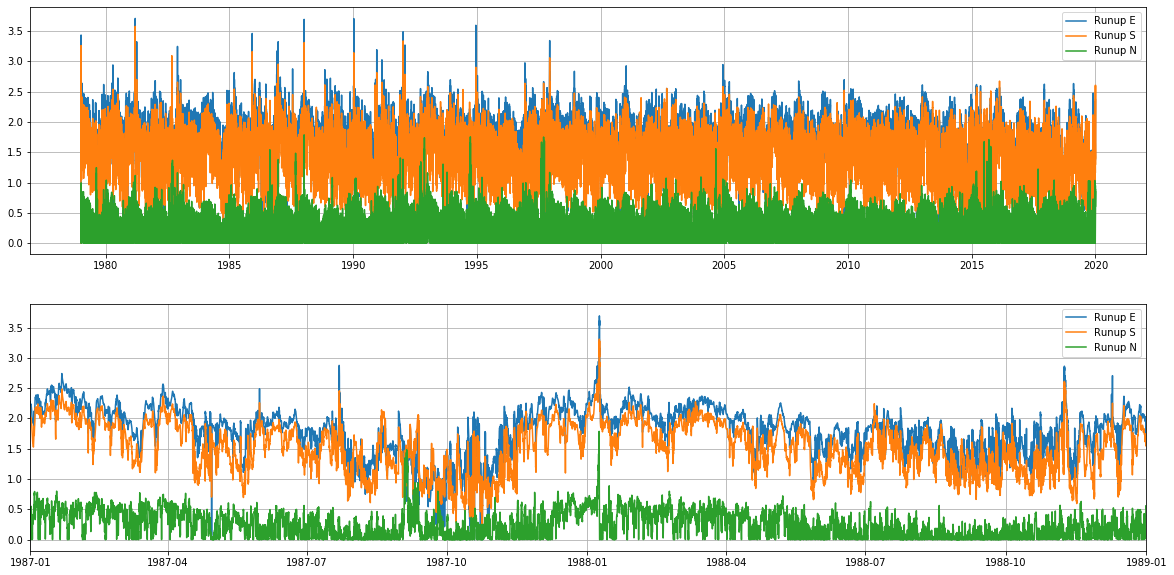

In [13]:
# plot runup

fig, axs = plt.subplots(2,1, figsize=(20,10))

axs[0].plot(out_hist_E.time, out_hist_E.runup, label='Runup E')
axs[0].plot(out_hist_S.time, out_hist_S.runup, label='Runup S')
axs[0].plot(out_hist_N.time, out_hist_N.runup, label='Runup N')
axs[0].legend()
axs[0].grid()

# zoom
axs[1].plot(out_hist_E.time, out_hist_E.runup, label='Runup E')
axs[1].plot(out_hist_S.time, out_hist_S.runup, label='Runup S')
axs[1].plot(out_hist_N.time, out_hist_N.runup, label='Runup N')
axs[1].legend()
axs[1].set_xlim(datetime.datetime(1987,1,1),datetime.datetime(1989,1,1))
axs[1].grid()

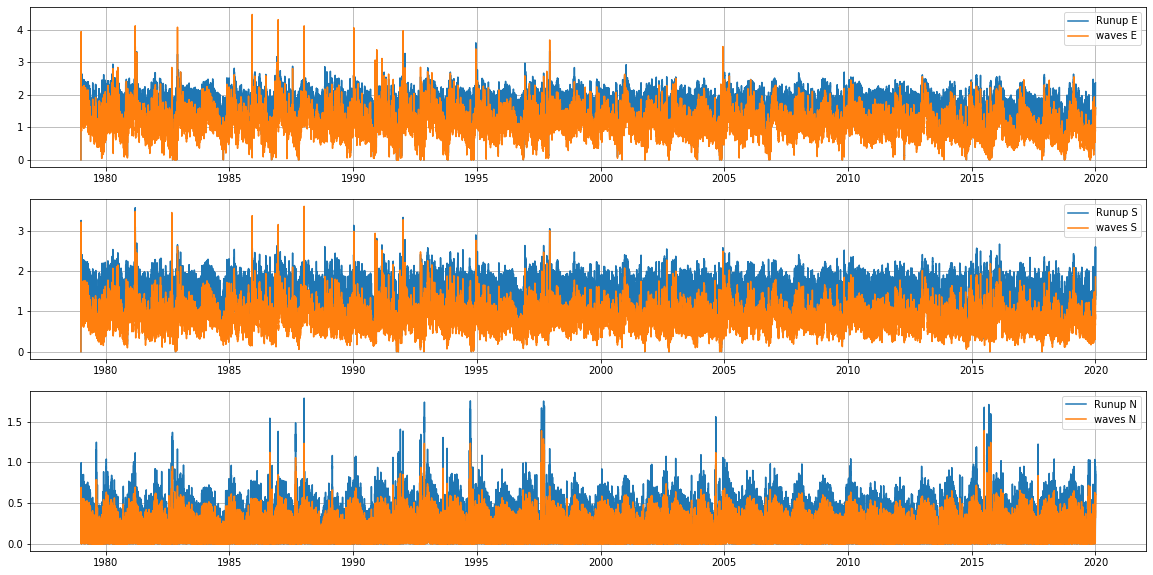

In [14]:
# plot comparison between waves and runup

fig, axs = plt.subplots(3,1, figsize=(20,10))
axs[0].plot(out_hist_E.time, out_hist_E.runup, label='Runup E')
axs[0].plot(out_hist_E.time, out_hist_E.hs, label='waves E')
axs[0].legend()
axs[0].grid()

axs[1].plot(out_hist_S.time, out_hist_S.runup, label='Runup S')
axs[1].plot(out_hist_S.time, out_hist_S.hs, label='waves S')
axs[1].legend()
axs[1].grid()

axs[2].plot(out_hist_N.time, out_hist_N.runup, label='Runup N')
axs[2].plot(out_hist_N.time, out_hist_N.hs, label='waves N')
axs[2].legend()
axs[2].grid()
